In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
!pip install shap
import shap

# SHAP
A medida que vamos desarrollando cada uno de los modelos nos encontramos con uno de los problemas más importantes de estos: su interpretabilidad. Si bien contamos con las métricas de cada uno y podemos hacer inferencia con datos propios, realmente no sabemos que pasa dentro del modelo. Incluso para el caso de regresión lineal, que contamos con los coeficientes, tenemos únicamente una explicación global del modelo, no tenemos un análisis local claro.

SHAP es una librería que nos permite dar explicatividad a una gran amplia cantidad de modelos. Mediante el SHAP value, se puede determinar cuán importante es una variable en una predicción en particular. De esta manera, se nos otorga la posibilidad de dar interpretación local.

También podemos dar con una interpretación global, teniendo en cuenta el promedio del SHAP value de cada variable, es decir, cuánto impacta cada variable en las predicciones.

## Visualizaciones
Para visualizar los valores SHAP, contamos con 4 gráficos: dos locales y dos globales.
### Locales
Sobre una predicción en particular
- Force plot: Comenzando desde un valor base, se muestra cuánto aporta cada variable mediante su valor SHAP hasta llegar a la predicción final.
- Waterfall plot: Casi identico al force plot, además nos ordena de mayor a menor las variables más influyentes.
### Globales
- Summary plot: Como mencionamos antes, se observa el promedio de los valores SHAP de cada variable.
- Beeswarm plot: Por cada variable se realiza un gráfico de dispersión respecto al valor shap que tiene cada registro. Aquellas secciones en donde haya una mayor densidad de puntos se acumularán verticalmente. Cuenta con colores que representan el valor relativo que tiene cada parametro (alto o bajo)

# Carga de datos y modelos
Definimos una clase SHAP_analysis la cual servirá para realizar gráficos de los modelos que querramos analizar. Está definido de manera tal que no solo acepta redes neuronales.

In [19]:
from sklearn.model_selection import train_test_split
class SHAP_analysis():
  def __init__(self):
    self.model = None

  def load_train_test(self, X_train, X_test, y_train, y_test):
    '''Método por si se quieren cargar los datos manualmente'''
    self.X_train = X_train
    self.X_test = X_test
    self.y_train = y_train
    self.y_test = y_test
    self.predict = None

  def load_model(self, model):
    '''
    Método para cargar el modelo y crear el análisis shap
    '''
    self.model = model
    # Inicializamos el explicador shap
    X_train_summary = shap.kmeans(self.X_train, 10) # Tenemos que compactar los datos que le damos al explicador por temas de memoria dinámica
    X_train_summary = shap.sample(self.X_train, 1000)
    self.explainer = shap.DeepExplainer(model,np.array(X_train_summary))
    self.expected_value = float(self.explainer.expected_value[0])
    try:
      self.shap_values = self.explainer.shap_values(np.array(self.X_test))
    except AttributeError:
      print('Error, no se han cargado los datos X,y')
      return
    self.explanation = shap.Explanation(values=self.shap_values[0], feature_names=self.X_train.columns.values)
    self.predict = self.model.predict(self.X_test)

  # Hallar percentil en el conjunto de test.
  # Nota: Como los shap_values son calculados sobre el conjunto de test, debemos hacer este cálculo respecto de este conjunto.
  def find_quantile(self,quantile=0.5):
    '''Buscar el indice del registro en shap_values correspondiente al cuartil'''
    if type(self.predict) == np.ndarray:
      reset_index_array = pd.Series(self.predict.flatten()).reset_index(drop=True) # Pasamos a series para dar robustez
    else:
      reset_index_array = self.predict.reset_index(drop=True)
    sorted_y_test = reset_index_array.sort_values()
    reset_index_array = sorted_y_test.reset_index()
    quantile_index = int(len(reset_index_array) * quantile)
    return reset_index_array['index'][quantile_index]

  # Visualizaciones locales
  def waterfall(self, register_index=0):
    shap.plots._waterfall.waterfall_legacy(self.expected_value, self.shap_values[0][register_index], feature_names=self.X_train.columns.values) # LOCAL, ver https://github.com/shap/shap/issues/1420

  def force_plot(self, register_index=0):
    shap.plots.force(self.expected_value, self.shap_values[0][register_index], self.X_test.iloc[register_index], matplotlib=True) # LOCAL

  # Visualizaciones globales
  def summary(self, max_display=None):
    shap.summary_plot(self.shap_values, self.X_test, feature_names=self.X_train.columns.values, plot_size=[10,6], max_display=max_display, title='Summary plot') # GLOBAL

  def beeswarm(self, max_display=None):
    shap.summary_plot(self.explanation, features= self.X_test, max_display=max_display, title='Beeswarm plot') # GLOBAL Ver error: https://stackoverflow.com/questions/75065673/deepshap-beeswarm-plot-only-shows-blue-dots-and-does-not-have-a-color-gradient-t


In [13]:
import pandas as pd
data = pd.read_csv('data.csv')
data = data.drop(['Unnamed: 0.1', 'Unnamed: 0'], axis=1)
data.columns

from sklearn.model_selection import train_test_split
X = data[['Location', 'MinTemp', 'MaxTemp', 'Evaporation',
       'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'Month']]
X = pd.get_dummies(X)

y = data['RainfallTomorrow']

X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X,y,test_size=0.3,random_state = 42)

y = data['RainTomorrow']
y = y.map({'Yes':1,'No':0})

X_train_clas, X_test_clas, y_train_clas, y_test_clas = train_test_split(X,y.values.reshape(-1,1),test_size=0.2,random_state = 42)

Cargar los modelos

In [5]:
class RedNeuronal_Clasificacion():
    def __init__(self):
      self.model = None

    def build_model(self, X):
        '''
        Construye un modelo de red neuronal con las capas y funciones de activación especificadas,
        se necesita brindar el vector X de variables independientes
        '''
        model = tf.keras.Sequential([
            tf.keras.layers.Dense(10, activation='relu', input_shape=(X.shape[1],)),
            tf.keras.layers.Dense(5, activation='relu'), # capa oculta
            tf.keras.layers.Dense(5, activation='relu'), # capa oculta
            tf.keras.layers.Dense(1, activation='sigmoid') # Capa output, al ser clasificación usamos una única neurona de salida con activación sigmoidea
        ])

        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']) # usamos como pérdida la entropía binaria usando como métrica la precisión
        ### imprimimos la cantidad de parámetros a modo de ejemplo
        print("n° de parámetros:", model.count_params())
        return model

    def fit(self, X, y, lr=0.1, epochs=1000, batch_size=100):
        ### esta es la función donde se entrena el modelo, fijarse que hay un learning rate e iteraciones.
        ### la función que fitea devuelve una historia de pérdida, que vamos a guardar para graficar la evolución.
        X = np.array(X)
        y = np.array(y)
        history = self.model.fit(X, y, epochs=epochs, batch_size=batch_size, verbose=0)
        self.loss_history = history.history['loss']
        return history.history['loss']

    def plot_loss_history(self):
        plt.plot(self.loss_history, label='NN')
        plt.legend()
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Training Loss Over Epochs')
        plt.show()

    def predict(self, X):
        X = np.array(X)
        predictions = self.model.predict(X)
        return predictions

    def save_model(self, filepath='model_classification.h5'):
        '''
        Guarda el modelo en un archivo dado por el filepath.
        '''
        self.model.save(filepath)

    def load_model(self, filepath='model_classification.h5'):
        '''
        Carga el modelo desde un archivo dado por el filepath.
        '''
        self.model = tf.keras.models.load_model(filepath)

class RedNeuronal_Regresion():
    def __init__(self):
      self.model = None

    def build_model(self, X):
        model = tf.keras.Sequential([
            tf.keras.layers.Dense(10, input_shape=(X.shape[1],)),
            tf.keras.layers.Activation('sigmoid'),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(6),  # hidden layer
            tf.keras.layers.Activation('sigmoid'),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(6),  # hidden layer
            tf.keras.layers.Activation('sigmoid'),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(1)
        ])
        custom_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
        model.compile(optimizer=custom_optimizer, loss='mean_squared_error')
        ### Cantidad de parámetros
        print("n° de parámetros:", model.count_params())
        return model

    def fit(self, X, y, lr=0.1, epochs=100, batch_size=100):
        X = np.array(X)
        y = np.array(y)
        history = self.model.fit(X, y, epochs=epochs, batch_size=batch_size, verbose=0)
        self.loss_history = history.history['loss']
        return history.history['loss']

    def plot_loss_history(self):
        plt.plot(self.loss_history, label='NN')
        plt.legend()
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Training Loss Over Epochs')
        plt.show()

    def predict(self, X):
        X = np.array(X)
        predictions = self.model.predict(X)
        return predictions

    def save_model(self, filepath='model_regression.h5'):
        '''
        Guarda el modelo en un archivo dado por el filepath.
        '''
        self.model.save(filepath)

    def load_model(self, filepath='model_regression.h5'):
        '''
        Carga el modelo desde un archivo dado por el filepath.
        '''
        self.model = tf.keras.models.load_model(filepath)

# Entrenar explicador SHAP

In [20]:
red_neuronal_reg = RedNeuronal_Regresion()
red_neuronal_clas = RedNeuronal_Clasificacion()

red_neuronal_reg.load_model()
red_neuronal_clas.load_model()

In [21]:
shap_analyzer_reg = SHAP_analysis()
shap_analyzer_clas = SHAP_analysis()

shap_analyzer_clas.load_train_test(X_train_clas, X_test_clas, y_train_clas, y_test_clas)
shap_analyzer_clas.load_model(red_neuronal_clas.model)

shap_analyzer_reg.load_train_test(X_train_reg, X_test_reg, y_train_reg, y_test_reg)
shap_analyzer_reg.load_model(red_neuronal_reg.model)

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


94/94 [==============================] - 0s 1ms/step


Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


141/141 [==============================] - 0s 2ms/step


# Creación de visualizaciones
## Regresión
### Explicatividad global

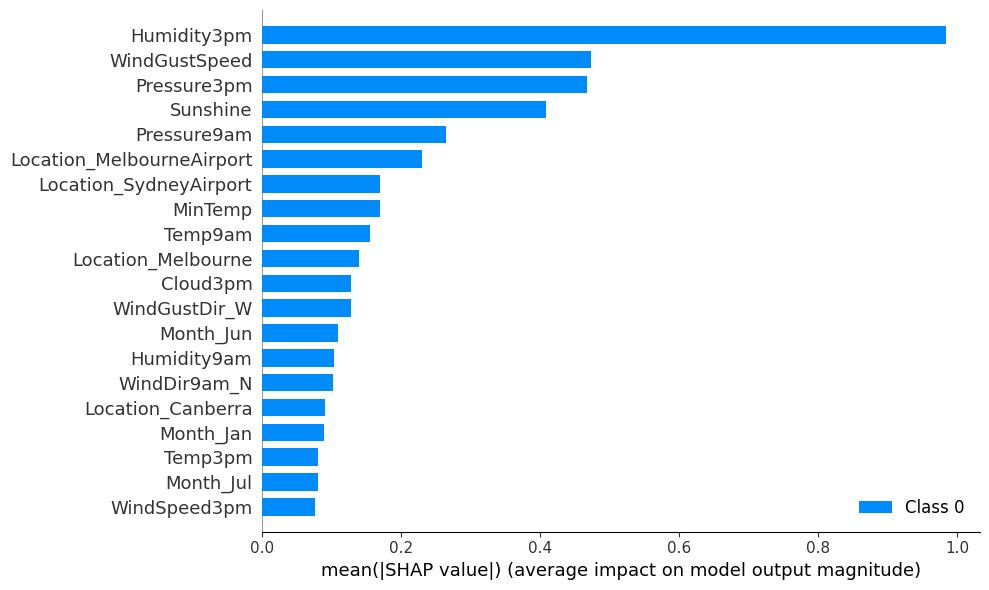

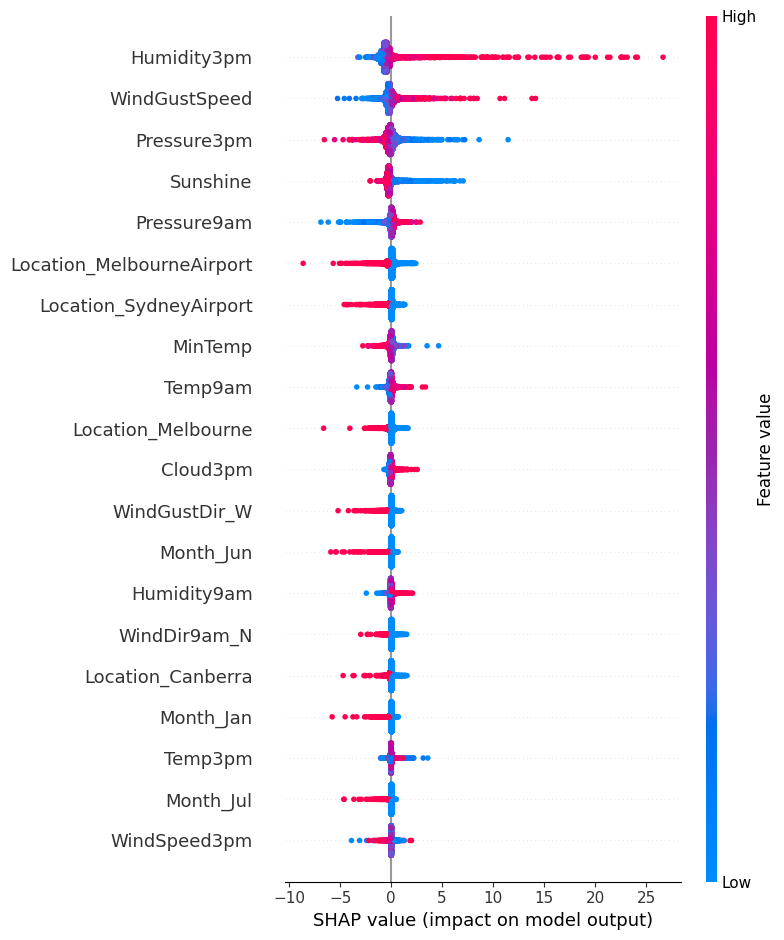

In [15]:
shap_analyzer_reg.summary()
shap_analyzer_reg.beeswarm()

Mediante estos gráficos podemos observar cuáles son las variables que más impacto tienen en el modelo para predecir la lluvia de mañana. Vemos que las primeras cinco son humedad, windgust, presión y sunshine. Además, en el gráfico beeswarm vemos información adicional. En efecto, podemos ver por ejemplo que los mayores predictores tienen una mayor distribución sobre valores de SHAP negativos, es decir, su impacto es mayor hacia restar en la predicción. Además, mediante el gradiente en el color de los registros, podemos observar una correlación entre cada variable y su valor SHAP, por ejemplo, a mayor humedad, mayor valor SHAP.

###Explicatibilidad local

Force plot y Waterfall sobre percentil 0.5
2238


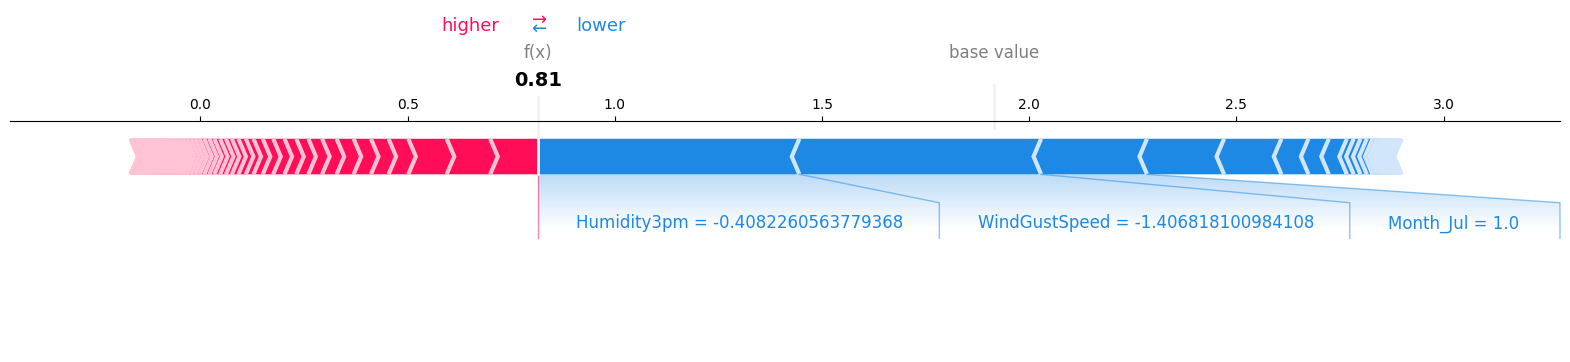

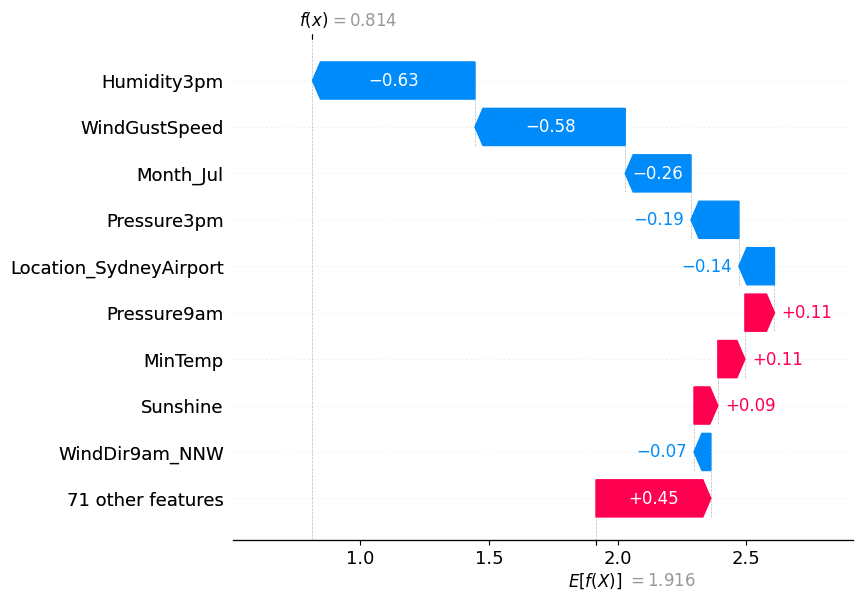

Force plot y Waterfall sobre percentil 0.95
4000


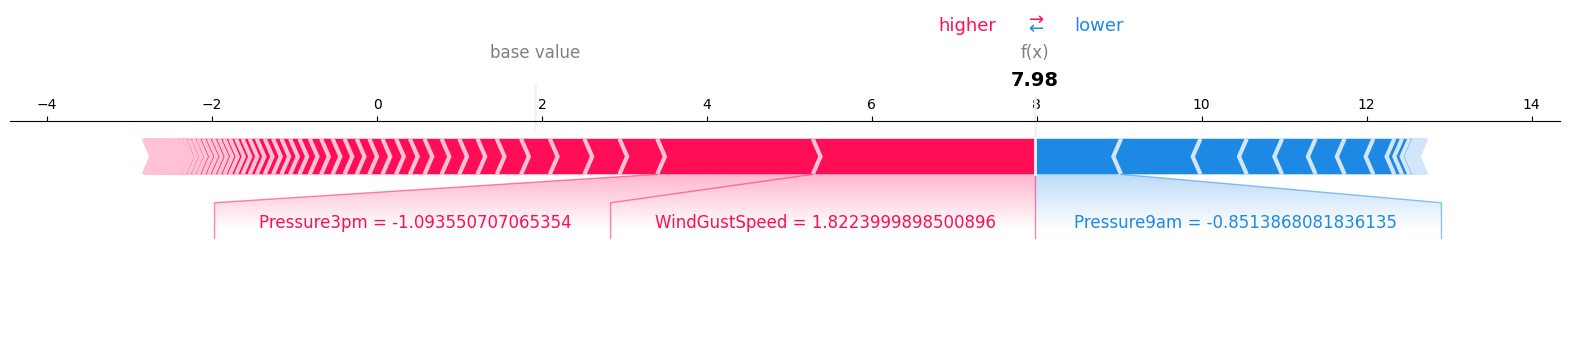

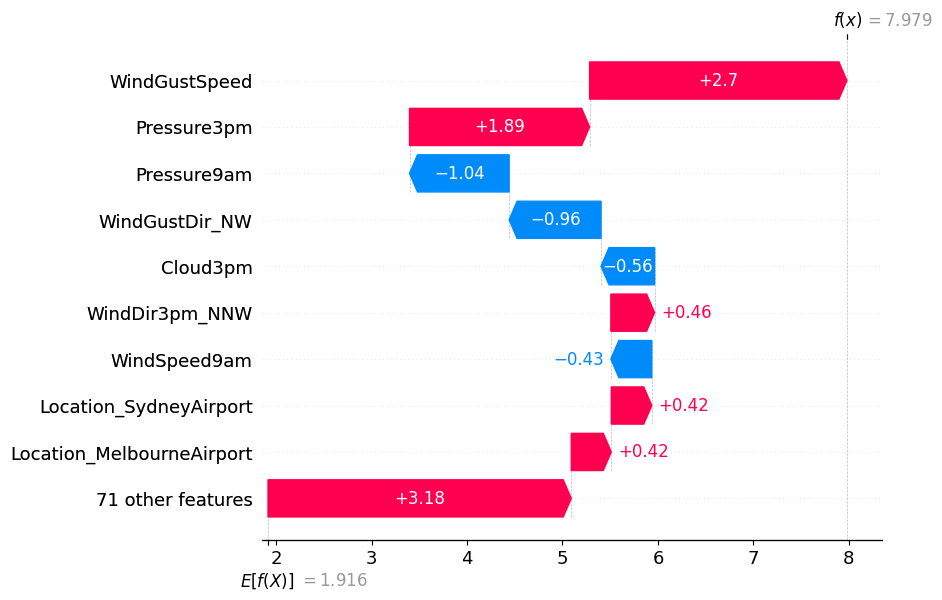

In [28]:
for percentil in [0.5,0.95]:
  print(f'Force plot y Waterfall sobre percentil {percentil}')
  percentil_ind = shap_analyzer_reg.find_quantile(percentil)
  print(percentil_ind)
  shap_analyzer_reg.force_plot(percentil_ind)
  shap_analyzer_reg.waterfall(percentil_ind)

Este pequeño bloque de código nos permite ver en más detalle cuáles son las variables que más impacto tienen en registros que representan los percentiles 0.5, 0.8 y 0.95.
- Percentil 0.5: Predicción: 0.81. Vemos que para poca lluvia los predictores que más impacto tuvieron fueron la humedad y el gust wind. Revisando el beeswarm, podemos concluir que valores bajos de estas variables fueron el mayor responsable.
- Percentil 0.95: Predicción: 7.98. Vemos que los mayores predictores fueron un valor alto de windgustspeed y un valor bajo de pressure3pm, segun los SHAP values y el análisis del beeswarm.

## Clasificación
### Explicatibilidad global

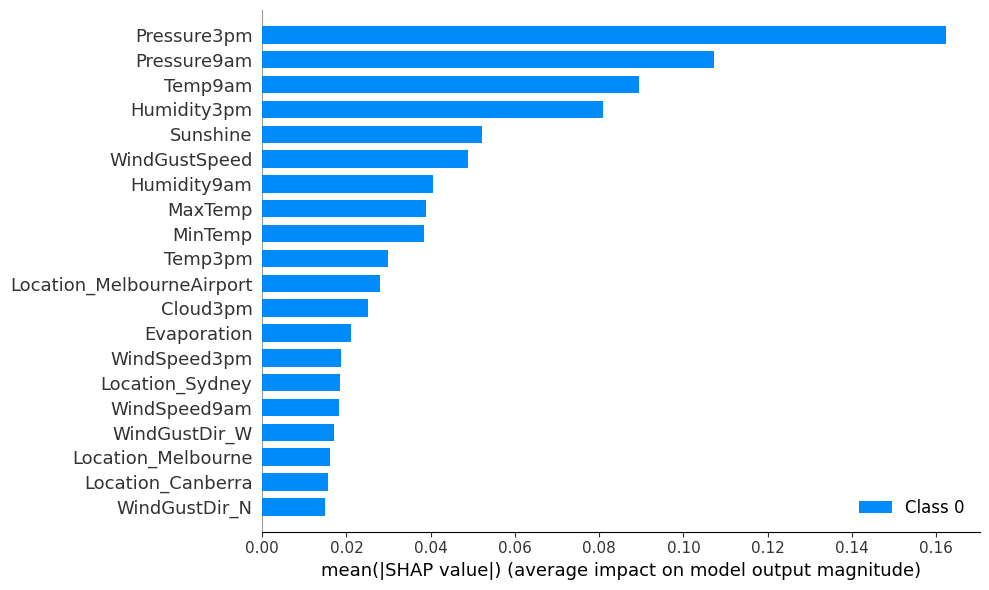

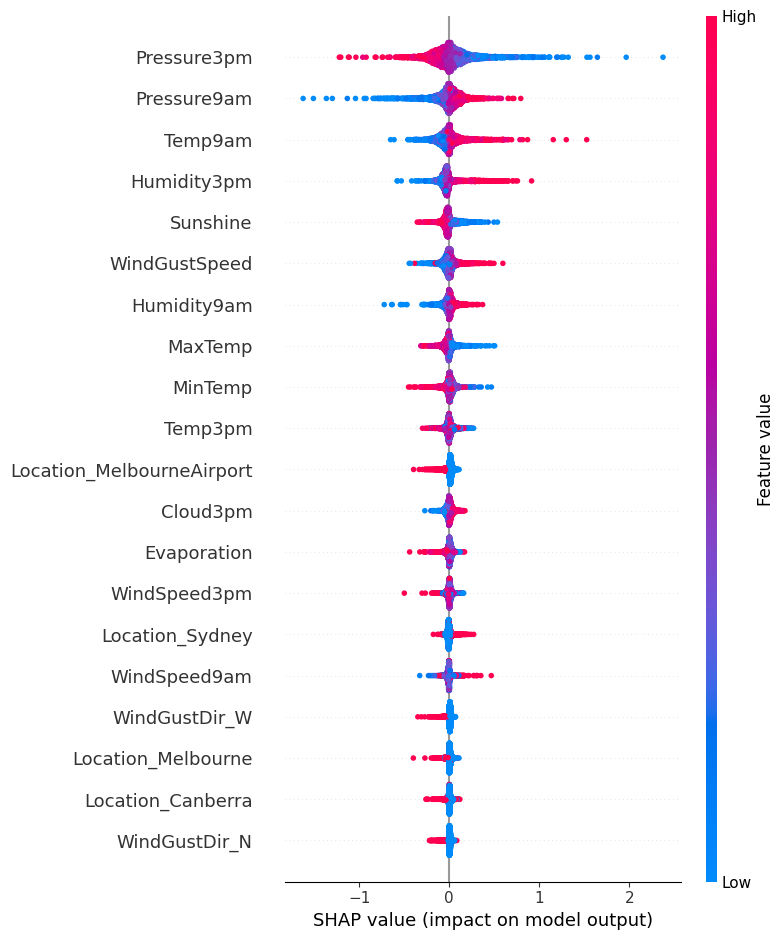

In [29]:
shap_analyzer_clas.summary()
shap_analyzer_clas.beeswarm()

Esta vez vemos que casi todas las variables están centradas en un SHAP nulo, esto no quiere decir que no tengan influencia.

Curiosamente, vemos que a pesar de ambos valores de presión son fuertes predictores para detectar si llueve o no mañana, el de las 3pm tiene SHAP values más bajos a medida que es más grande, mientras que la de las 9am es lo contrario.

### Explicatibilidad local

Force plot y Waterfall sobre percentil 0.5
309


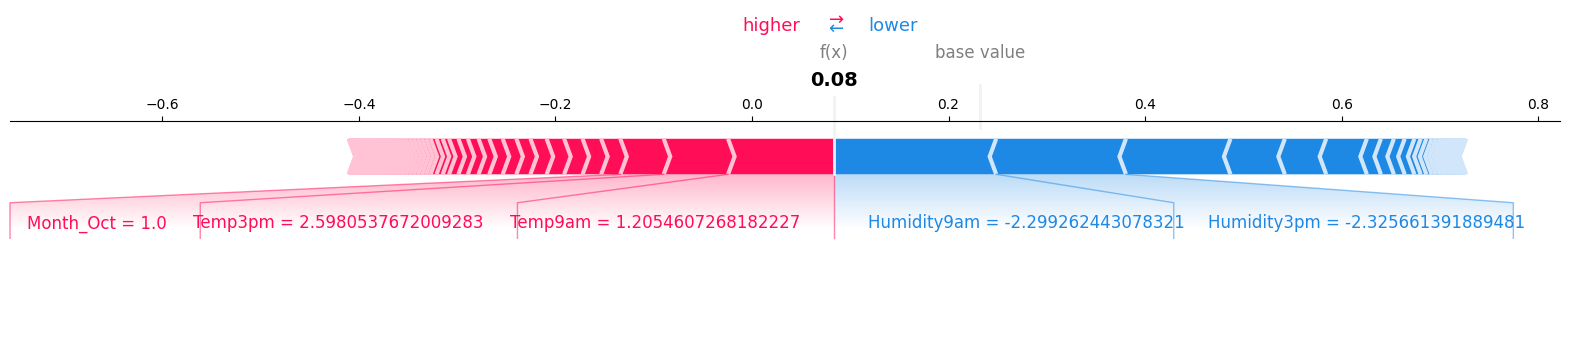

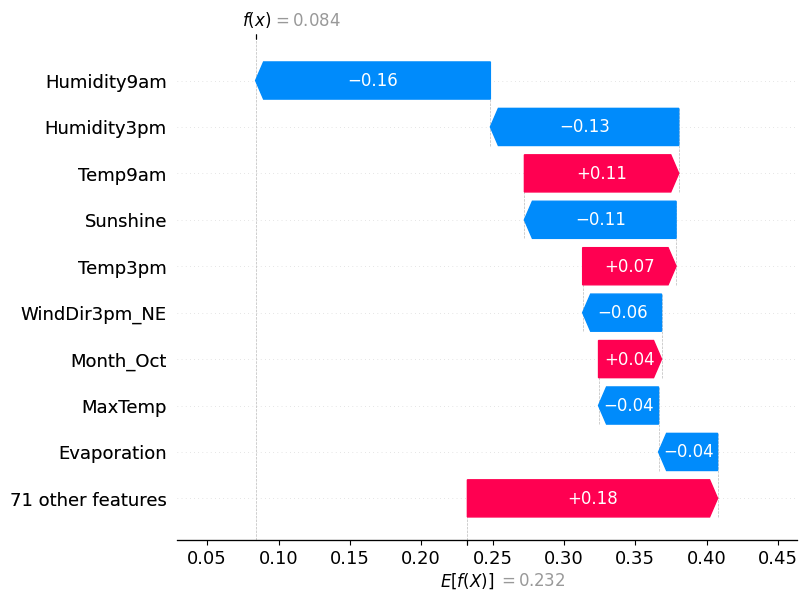

Force plot y Waterfall sobre percentil 0.9
1739


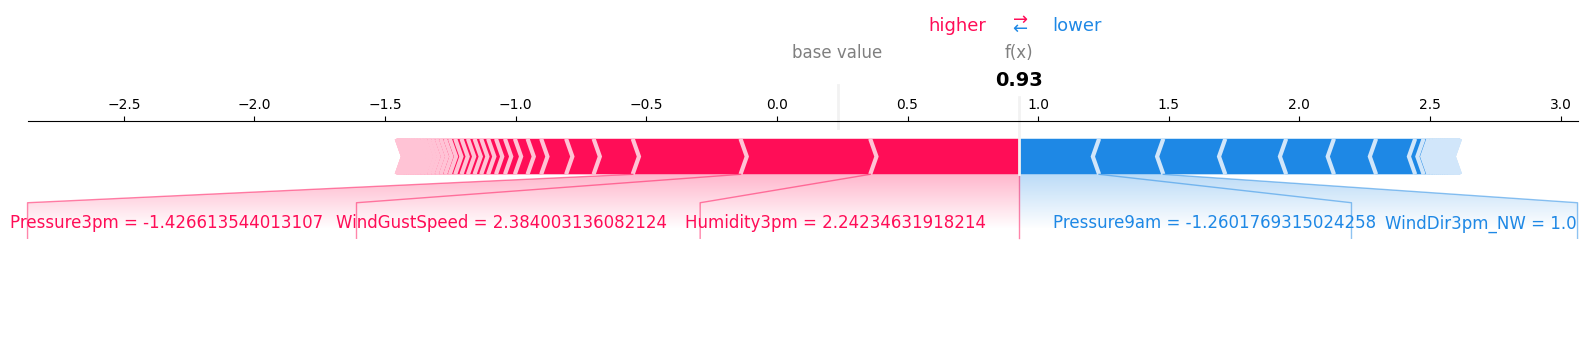

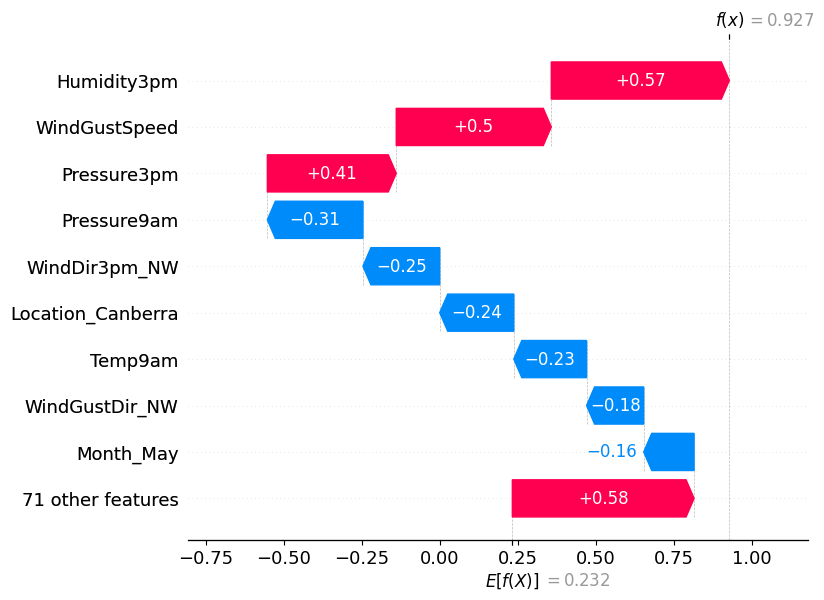

In [32]:
for percentil in [0.5,0.9]:
  print(f'Force plot y Waterfall sobre percentil {percentil}')
  percentil_ind = shap_analyzer_clas.find_quantile(percentil)
  print(percentil_ind)
  shap_analyzer_clas.force_plot(percentil_ind)
  shap_analyzer_clas.waterfall(percentil_ind)

Podemos ver como valores bajos de la humedad fueron los predictores más fuertes para determinar que no hay lluvia mientras que una humedad, presión y windgustspeed fueron los más fuertes para determinar que sí hay.